In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from scipy import stats
import matplotlib.colors as colors
from matplotlib import rcParams
import cmasher as cmr
import os
path = os.getenv("DATADIR")
data_dir = path+ "0_SUMS_Catalogs/"
plt.style.use(path+'bl.mplstyle')

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def density(x,y):
    # Top cat styling for bulk of points 
    x = x[np.isfinite(x)]
    y = y[np.isfinite(y)]
    xy = np.vstack([x,y])
    z = stats.gaussian_kde(xy)(xy)
    index = z.argsort()
    x, y, z = np.array(x)[index], np.array(y)[index], np.array(z)[index]
    return x,y,z

lmc = pd.read_csv(data_dir+'CompleteCatalog/Step4/lmc_photometry.csv')
smc = pd.read_csv(data_dir+'CompleteCatalog/Step4/smc_photometry.csv')
df = pd.concat([lmc,smc])

mags = df[['uvw2_mag','uvm2_mag','uvw1_mag']].values.flatten()
errs = df[['uvw2_mag_err','uvm2_mag_err','uvw1_mag_err']].values.flatten()

errs = errs[~np.isnan(mags)]
mags = mags[~np.isnan(mags)]

n_points = 250_000
    
rand_int = np.random.randint(len(mags)+1, size=(n_points))

# Takes a long time to get the kde to run this way
run = False
if run:
    kde_err,kde_mag,kde_z = density(errs[rand_int],mags[rand_int])
    np.savetxt(f'MagVErrKDE_{n_points}.txt',(kde_err,kde_mag,kde_z))
else:
    kde_err,kde_mag,kde_z = np.loadtxt(data_dir +f'KDEs/MagVErrKDE_{n_points}.txt')

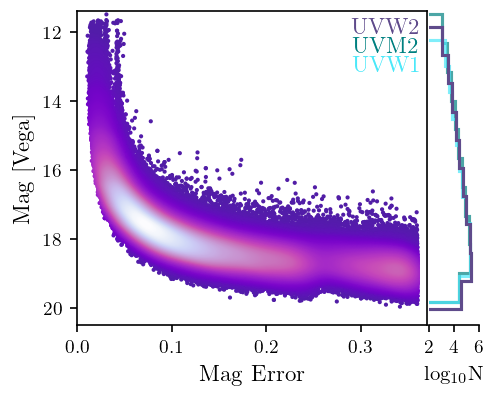

In [ ]:
c_min = 0.3
c_max = 0.99

trunc_cmap =  truncate_colormap(cmr.gothic, c_min,c_max)
# Start with a square Figure.
fig = plt.figure(figsize=(3.35, 3.35),dpi=150)
# Have to set this up a little strange for the plot to be square.
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(7,1),height_ratios=(1, 4),left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.01, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1,0])
bx = fig.add_subplot(gs[1,1],sharey=ax)

# the scatter plot:
ax.scatter(kde_err,kde_mag,c=kde_z,s=1,zorder=0,cmap=trunc_cmap,label="")
ax.set_ylim(20.5,11.4)
ax.set_xlim(0.0,0.37)

uvw2_mags = df['uvw2_mag'].values
uvm2_mags = df['uvm2_mag'].values
uvw1_mags = df['uvw1_mag'].values
uvw2_mags = uvw2_mags[~np.isnan(uvw2_mags)]
uvm2_mags = uvm2_mags[~np.isnan(uvm2_mags)]
uvw1_mags = uvw1_mags[~np.isnan(uvw1_mags)]

cols = ['#5f4b8b','#008080','#4be8f9'] 
cols = ['#6c3baa','#262728','#FF007F'] 
cols  = ['#5f4b8b','#008080','#4be8f9'] 
bx.hist(uvw2_mags, orientation='horizontal',label='UVW2',color=cols[0],histtype='step',lw=1.5,zorder=10,alpha=1);
bx.hist(uvm2_mags, orientation='horizontal',label='UVM2',color=cols[1],histtype='step',lw=1.5,alpha=0.7);
bx.hist(uvw1_mags, orientation='horizontal',label='UVW1',color=cols[2],histtype='step',lw=1.5,alpha=0.7);
bx.set_xscale('log')

bx.set_xlim(10**2.,10**6)
bx.set_xticks([10**2, 10**4, 10**6])
bx.set_xticklabels([2, 4,6])
bx.set_yticklabels([])
# Turn off spines 
bx.spines['left'].set_visible(False)
bx.spines['right'].set_visible(False)
bx.spines['top'].set_visible(False)
bx.yaxis.set_visible(False)

# Set labels
ax.set_xlabel('Mag Error')
ax.set_ylabel('Mag [Vega]')
bx.set_xlabel(r'log$_{10}$N',fontsize=10)

uvw2_errs = df['uvw2_mag_err'].values
uvm2_errs = df['uvm2_mag_err'].values
uvw1_errs = df['uvw1_mag_err'].values
uvw2_errs = uvw2_errs[~np.isnan(uvw2_errs)]
uvm2_errs = uvm2_errs[~np.isnan(uvm2_errs)]
uvw1_errs = uvw1_errs

spacing = 0.06
ytext = 0.98
xtext = -0.2
textfontsize = 11
bx.text(xtext+0.03, ytext , 'UVW2', verticalalignment='top', horizontalalignment='right',
        transform=bx.transAxes, color=cols[0], fontsize=textfontsize,weight='bold')
bx.text(xtext, ytext-spacing, 'UVM2', verticalalignment='top', horizontalalignment='right',
        transform=bx.transAxes, color=cols[1], fontsize=textfontsize,weight='bold')
bx.text(xtext+0.05, ytext-(2*spacing), 'UVW1', verticalalignment='top', horizontalalignment='right',
        transform=bx.transAxes, color=cols[2], fontsize=textfontsize,weight='bold')

ax.set_yticks([20,18,16,14,12])
ax.set_yticklabels([20,18,16,14,12])

# Hard to get a vectorized version that works, taking a screenshot of this plot seems like the best quality option I can find. 
plt.savefig('MagVErrKDE.pdf',dpi=1000,bbox_inches='tight')